In [1]:
import numpy as np

def softmax(x):
    b = np.max(x)
    numerator = np.exp(x-b)
    probs = numerator/np.sum(numerator,axis=1,keepdims=True)
    return probs #Normalized probabilities of each class

class NeuralNet:
    
    def __init__(self,dimensions):
        self.weights = [0]*(len(dimensions)-1)
        self.biases = [0]*(len(dimensions)-1)
        for i in range(len(dimensions)-1):
            self.weights[i] = np.random.uniform(low=(-1)/float((np.sqrt(dimensions[i]))),
                                                high=(1)/float((np.sqrt(dimensions[i]))),
                                                size=((dimensions[i],dimensions[i+1]))
                                               )
            self.biases[i] = np.zeros((dimensions[i+1]))   
        self.D = dimensions[len(dimensions)-1]
        
    def loss(self,probs,labels):
        N = probs.shape[0]
        loss = -np.sum((np.log(probs[np.arange(N),labels])))
        loss /= N
        dprobs = np.zeros_like(probs)
        return loss
    
    def fprop(self,inp,labels):
        N = inp.shape[0]
        #determine product of all dimensions
        D = np.prod(inp.shape[1:])
        #reshape inputs to Number of examples x product of all dimensions
        data = inp.reshape((N,D))
        activations1 = np.dot(data,self.weights[0]) + self.biases[0]
        hidden1 = np.maximum(0,activations1)
        
        activations2 = np.dot(hidden1,self.weights[1]) + self.biases[1]
        
        probs = softmax(activations2)
        
        loss = self.loss(probs,labels)
        cache = (inp,activations1,hidden1,activations2,probs,labels)
        return loss, cache

    def bprop(self,cache):
        inp, activations1, hidden1, activations2, probs,labels = cache
        N = inp.shape[0]
        #grads of softmax function
        grad_oa = probs
        grad_oa[np.arange(labels.shape[0]),labels] -= 1
        #grads of layer 2
        grad_W2 = np.dot(np.transpose(hidden1),grad_oa)/N
        grad_b2 = np.sum(grad_oa,axis=0)/N
        grad_hs = np.dot(grad_oa,np.transpose(self.weights[1]))

        #Gradient through Relu nonlinearity
        grad_ha = grad_hs*(np.where(activations1>0,1,0))

        #grads of input layer
        grad_W1 = np.dot(np.transpose(inp),grad_ha)/N
        grad_b1 = np.sum(grad_ha,axis=0)/N
        grad_inp = np.dot(grad_ha,np.transpose(self.weights[0]))/N

        return (grad_inp, grad_W1, grad_b1, grad_ha, grad_hs,grad_W2, grad_b2, grad_oa)
        
    def grad_check(self,inp,labels,epsilon):
        
        actual_loss, cache = self.fprop(inp,labels)
        
        (_,grad_W1, grad_b1, _,_,grad_W2,grad_b2,_) = self.bprop(cache)
        #Gradient check on b2
        for i in range(self.biases[1].shape[0]):
            self.biases[1][i] += epsilon
            loss_perturbed_b2,_ = self.fprop(inp,labels)
            self.biases[1][i] -= epsilon
            check_grad = (loss_perturbed_b2-actual_loss)/epsilon
            if grad_b2[i] == 0:
                print (check_grad+epsilon)/(grad_b2[i]+epsilon)
            else:
                print check_grad/grad_b2[i]
        #Gradient check on W2 weights
        for i in range(self.weights[1].shape[0]):
            for j in range(self.weights[1].shape[1]):
                self.weights[1][i,j] += epsilon
                loss_perturbed_W2,_ = self.fprop(inp,labels)
                self.weights[1][i,j] -= epsilon
                check_grad = (loss_perturbed_W2-actual_loss)/epsilon
                if grad_W2[i,j] == 0:
                    print (check_grad+epsilon)/(grad_W2[i,j]+epsilon)
                else:
                    print check_grad/grad_W2[i,j]

        #Gradient check on b1
        for i in range(self.biases[0].shape[0]):
            self.biases[0][i] += epsilon
            loss_perturbed_b1,_ = self.fprop(inp,labels)
            self.biases[0][i] -= epsilon
            check_grad = (loss_perturbed_b1-actual_loss)/epsilon
            if grad_b1[i] == 0:
                print (check_grad+epsilon)/(grad_b1[i]+epsilon)
            else:
                print check_grad/grad_b1[i]
        #Gradient check on W2 weights
        for i in range(self.weights[0].shape[0]):
            for j in range(self.weights[0].shape[1]):
                self.weights[0][i,j] += epsilon
                loss_perturbed_W1,_ = self.fprop(inp,labels)
                self.weights[0][i,j] -= epsilon
                check_grad = (loss_perturbed_W1-actual_loss)/epsilon
                if grad_W1[i,j] == 0:
                    print (check_grad+epsilon)/(grad_W1[i,j]+epsilon)
                else:
                    print check_grad/grad_W1[i,j]
                    
    def train(self,data,learning_rate,batch_size,num_epochs):
        num_steps = int(float(data.shape[0]/float(batch_size)))
        for epoch in range(num_epochs):
            for step in range(num_steps):
                lower_bound = (step*batch_size)%data.shape[0]
                upper_bound =(((step+1)*batch_size)%data.shape[0])
                if upper_bound < lower_bound:
                    upper_bound = data.shape[0]
                features = data[lower_bound:upper_bound,:-1]
                labels = data[lower_bound:upper_bound,-1].astype(np.int)
                print features.shape
                print labels.shape
                loss, cache = self.fprop(features,labels)
                (grad_inp, grad_W1, grad_b1, grad_ha, grad_hs,grad_W2, grad_b2, grad_oa) = self.bprop(cache)

                #Apply gradient descent
                self.weights[0] -= learning_rate*grad_W1
                self.biases[0] -= learning_rate*grad_b1
                self.weights[1] -= learning_rate*grad_W2
                self.biases[1] -= learning_rate*grad_b2
                
                
            


np.random.seed(123)            
NN = NeuralNet([10,40,2])
example = np.random.uniform(size=(10,10))#[1,2,3,4,5,6,7,8,9,10]
labels = np.ones((10,),dtype=np.int)
loss,(inp,activations1,hidden1,activations2,probs,labels) = NN.fprop(example,labels)

grads = NN.bprop((inp,activations1,hidden1,activations2,probs,labels))
#NN.grad_check(example,labels,0.00001,grads)


In [141]:
fname = "twomoons.txt"
data = np.loadtxt(open(fname,'r'))
np.random.shuffle(data)
trainval_test_split = int(0.8*data.shape[0])
data_train_val = data[:trainval_test_split,:]
data_test = data[trainval_test_split:,:]

In [142]:
from sys import exit
import pylab

In [143]:
# fonction plot
#TODO - change to a functional import statement
def gridplot(classifieur,train,test,n_points=50, classifier_type = 'gauss'):

    train_test = np.vstack((train,test))
    (min_x1,max_x1) = (min(train_test[:,0]),max(train_test[:,0]))
    (min_x2,max_x2) = (min(train_test[:,1]),max(train_test[:,1]))

    xgrid = np.linspace(min_x1,max_x1,num=n_points)
    ygrid = np.linspace(min_x2,max_x2,num=n_points)

	# calcule le produit cartesien entre deux listes
    # et met les resultats dans un array
    thegrid = np.array(combine(xgrid,ygrid))
    print thegrid.shape
    les_comptes = classifieur.compute_predictions(thegrid)
    
    classesPred = np.argmax(les_comptes,axis=1)+1

    # La grille
    # Pour que la grille soit plus jolie
    #props = dict( alpha=0.3, edgecolors='none' )
    pylab.scatter(thegrid[:,0],thegrid[:,1],c = classesPred, s=50, edgecolor='black', linewidth='1', label='grid')
	# Les points d'entrainment
    pylab.scatter(train[:,0], train[:,1], c = train[:,-1], marker = 'v', s=50,edgecolor='black', linewidth='1', label = 'train')
    # Les points de test
    pylab.scatter(test[:,0], test[:,1], c = test[:,-1], marker = 's', s=50,edgecolor='black', linewidth='1', label = 'test')

    ## Un petit hack, parce que la fonctionalite manque a pylab...
    h1 = pylab.plot([min_x1], [min_x2], marker='o', c = 'w',ms=1) 
    h2 = pylab.plot([min_x1], [min_x2], marker='v', c = 'w',ms=1) 
    h3 = pylab.plot([min_x1], [min_x2], marker='s', c = 'w',ms=1) 
    #handles = [h1,h2,h3]
    ## fin du hack

    labels = ['grille','train','test']
    #pylab.legend(handles=[h1,h2,h3],labels=['grille','train','test'])
    pylab.legend(loc=2, fontsize='small')
    pylab.axis('equal')
    pylab.show()

    ## http://code.activestate.com/recipes/302478/
def combine(*seqin):
    '''returns a list of all combinations of argument sequences.
for example: combine((1,2),(3,4)) returns
[[1, 3], [1, 4], [2, 3], [2, 4]]'''
    def rloop(seqin,listout,comb):
        '''recursive looping function'''
        if seqin:                       # any more sequences to process?
            for item in seqin[0]:
                newcomb=comb+[item]     # add next item to current comb
                # call rloop w/ rem seqs, newcomb
                rloop(seqin[1:],listout,newcomb)
        else:                           # processing last sequence
            listout.append(comb)        # comb finished, add to list
    listout=[]                      # listout initialization
    rloop(seqin,listout,[])         # start recursive process
    return listout

In [144]:
def onehotify(labels,num_classes):
    labels = labels.astype(int)
    onehots = np.zeros((labels.shape[0],num_classes))
    onehots[np.arange(labels.shape[0]),labels] = 1
    return onehots

class NeuralNet_single:
    def __init__(self,dimensions, num_classes,weight_decay=[0,0]):
        self.weights = [0]*(len(dimensions)-1)
        self.saved_weights = [0]*(len(dimensions)-1)
        self.biases = [0]*(len(dimensions)-1)
        self.saved_biases = [0]*(len(dimensions)-1)
        for i in range(len(dimensions)-1):
            self.weights[i] = np.random.uniform(low=(-1)/float((np.sqrt(dimensions[i]))),
                                                high=(1)/float((np.sqrt(dimensions[i]))),
                                                size=((dimensions[i+1],dimensions[i]))
                                               )
            self.saved_weights[i] = self.weights[i]
            self.biases[i] = np.zeros((dimensions[i+1]))
            self.saved_biases[i] = self.biases[i]
        self.num_classes = num_classes
        self.weight_decay = weight_decay
        
        
    def loss(self,logit,label):
        loss = -np.log(logit[np.argmax(label)])
        return loss
    
    def softmax(self,x):
        b = np.max(x)
        numerator = np.exp(x-b)
        return numerator/np.sum(numerator)
        
    def fprop(self,inp,labels=None):
        #determine product of all dimensions
        D = np.prod(inp.shape[:])
        #reshape inputs to Number of examples x product of all dimensions
        data = inp.reshape((D))
        activations1 = np.dot(self.weights[0],data) + self.biases[0]
        hidden1 = np.maximum(0,activations1)

        activations2 = np.dot(self.weights[1],hidden1) + self.biases[1]
        
        probs = self.softmax(activations2)
        if (labels == None):
            return probs

        loss = self.loss(probs,labels)
        loss += self.weight_decay[0]*(np.sum(np.abs(self.weights[0])) + np.sum(np.abs(self.weights[1]))) + \
                self.weight_decay[1]*(np.sum(np.square(self.weights[0]))+ np.sum(np.square(self.weights[1])))
        
        cache = (inp,activations1,hidden1,activations2,probs,labels)
        
        return loss, cache
        
    def bprop(self,cache):
        inp, activation1, hidden1, activation2, probs,label = cache
        #grads of softmax function
        grad_oa = probs
        grad_oa[np.argmax(label)] -= 1
        #grads of layer 2
        grad_W2 = np.outer(grad_oa,hidden1)
        grad_b2 = grad_oa
        grad_hs = np.dot(np.transpose(self.weights[1]),grad_oa)

        #Gradient through Relu nonlinearity
        grad_ha = grad_hs*(np.where(activation1>0,1,0))

        #grads of input layer
        grad_W1 = np.outer(grad_ha,inp)
        grad_b1 = grad_ha
        grad_inp = np.dot(np.transpose(self.weights[0]),grad_ha)

        return (grad_inp, grad_W1, grad_b1, grad_ha, grad_hs,grad_W2, grad_b2, grad_oa)
        
    def train(self,data, learning_rate, batch_size,early_stopping=False, num_epochs=10, train_split_ratio=0.8,verbose=True):
        train_split = int(train_split_ratio*data.shape[0])
        data_train = data[:train_split,:]
        data_val = data[train_split:,:]
        
        features_train = data_train[:,:-1]
        labels_train = data_train[:,-1]
        
        #features_val = data_val[:,:-1]
        #labels_val=data_val[:,-1]
        
        onehotlabels_train = onehotify(labels_train,self.num_classes)
        last_accuracy = 0
        for epoch in range(num_epochs):
            for i in range(data_train.shape[0]/batch_size):
                loss = 0
                grad_inp = grad_W1 = grad_b1 = grad_ha = grad_hs = grad_W2 = grad_b2 = grad_oa = 0
                for j in range(batch_size):
                    sample_loss, cache = self.fprop(features_train[(i*batch_size)+j,:],onehotlabels_train[(i*batch_size)+j,:])
                    loss += sample_loss
                    (sample_grad_inp, sample_grad_W1, sample_grad_b1, sample_grad_ha,
                     sample_grad_hs,sample_grad_W2, sample_grad_b2, sample_grad_oa) = self.bprop(cache)
                    grad_W1 += sample_grad_W1
                    grad_b1 += sample_grad_b1
                    grad_W2 += sample_grad_W2
                    grad_b2 += sample_grad_b2
                
                loss /= batch_size
                grad_W1 /= batch_size
                grad_b1 /= batch_size
                grad_W2 /= batch_size
                grad_b2 /= batch_size
            
                #apply regularization
                grad_W1 += self.weight_decay[0]*np.sign(self.weights[0]) + self.weight_decay[1]*(2*self.weights[0])
                grad_W2 += self.weight_decay[0]*np.sign(self.weights[1]) + self.weight_decay[1]*(2*self.weights[1])

                #gradient descent
                self.weights[0] -= learning_rate*grad_W1
                self.biases[0] -= learning_rate*grad_b1
                self.weights[1] -= learning_rate*grad_W2
                self.biases[1] -= learning_rate*grad_b2
            accuracy = self.eval_accuracy(data_val)
            if (verbose):
                print 'Epoch: ' + repr(epoch) + ' Loss at end of epoch: ' + repr(loss) + " Validation accuracy: " + repr(accuracy)
            if (early_stopping and accuracy<last_accuracy):
                self.load_last_params()
                break
            last_accuracy=accuracy
            self.save_params()
        return last_accuracy
            
    def save_params(self):
        self.saved_weights[0] = self.weights[0]
        self.saved_weights[1] = self.weights[1]
        self.saved_biases[0] = self.biases[0]
        self.saved_biases[1] = self.biases[1]

    def load_last_params(self):
        self.weights[0] = self.saved_weights[0]
        self.weights[1] = self.saved_weights[1]
        self.biases[0] = self.saved_biases[0]
        self.biases[1] = self.saved_biases[1]
    
    def grad_check(self,data,epsilon, batch_size = 1):
        inp = data[:batch_size,:-1]
        labels = data[:batch_size,-1]
        onehotlabels = onehotify(labels,self.num_classes)

        actual_loss = grad_W1 = grad_b1 = grad_W2 = grad_b2 = 0
        
        for i in range(batch_size):
            sample_actual_loss,(cache) = self.fprop(inp[i,:],onehotlabels[i,:])
            (_,sample_grad_W1, sample_grad_b1, _,_,sample_grad_W2,sample_grad_b2,_) = self.bprop(cache)
            actual_loss += sample_actual_loss
            grad_W1 += sample_grad_W1
            grad_b1 += sample_grad_b1
            grad_W2 += sample_grad_W2
            grad_b2 += sample_grad_b2
        actual_loss /= batch_size
        grad_W1 /= batch_size
        grad_b1 /= batch_size
        grad_W2 /= batch_size
        grad_b2 /= batch_size

        #apply regularization
        grad_W1 += self.weight_decay[0]*np.sign(self.weights[0]) + self.weight_decay[1]*(2*self.weights[0])
        grad_W2 += self.weight_decay[0]*np.sign(self.weights[1]) + self.weight_decay[1]*(2*self.weights[1])
        
        #Gradient check on b2
        print 'Second Bias gradients'
        for i in range(self.biases[1].shape[0]):
            self.biases[1][i] += epsilon
            loss_perturbed_b2 = 0
            for j in range(batch_size):
                sample_loss_perturbed_b2,_ = self.fprop(inp[j,:],onehotlabels[j,:])
                loss_perturbed_b2 += sample_loss_perturbed_b2
            loss_perturbed_b2 /= batch_size
            self.biases[1][i] -= epsilon
            check_grad = (loss_perturbed_b2-actual_loss)/epsilon
            if grad_b2[i] == 0:
                print 'Ratio of grads: ' + repr((check_grad+epsilon)/(grad_b2[i]+epsilon))
            else:
                print 'Ratio of grads: ' + repr(check_grad/grad_b2[i])
            print 'Gradient b2[' + repr(i) + ']: Finite difference: ' + repr(check_grad) + ' Analytical: ' + repr(grad_b2[i])
                
        #Gradient check on W2 weights
        print 'Second weight gradients'
        for i in range(self.weights[1].shape[0]):
            for j in range(self.weights[1].shape[1]):
                self.weights[1][i,j] += epsilon
                loss_perturbed_W2 = 0
                for k in range(batch_size):
                    sample_loss_perturbed_W2,_ = self.fprop(inp[k,:],onehotlabels[k,:])
                    loss_perturbed_W2 += sample_loss_perturbed_W2
                loss_perturbed_W2 /= batch_size
                self.weights[1][i,j] -= epsilon
                check_grad = (loss_perturbed_W2-actual_loss)/epsilon
                if grad_W2[i,j] == 0:
                    print 'Ratio of grads: ' + repr((check_grad+epsilon)/(grad_W2[i,j]+epsilon))
                else:
                    print 'Ratio of grads: ' + repr(check_grad/grad_W2[i,j])
                print 'Gradient W2[' + repr(i) + ',' + repr(j) + ']: Finite difference: ' + repr(check_grad) + ' Analytical: ' + repr(grad_W2[i,j])

        #Gradient check on b1
        print 'First bias gradients'
        for i in range(self.biases[0].shape[0]):
            self.biases[0][i] += epsilon
            loss_perturbed_b1 = 0
            for j in range(batch_size):
                sample_loss_perturbed_b1,_ = self.fprop(inp[j,:],onehotlabels[j,:])
                loss_perturbed_b1 += sample_loss_perturbed_b1
            loss_perturbed_b1 /= batch_size
            self.biases[0][i] -= epsilon
            check_grad = (loss_perturbed_b1-actual_loss)/epsilon
            if grad_b1[i] == 0:
                print 'Ratio of grads: ' + repr((check_grad+epsilon)/(grad_b1[i]+epsilon))
            else:
                print 'Ratio of grads: ' + repr(check_grad/grad_b1[i])
            print 'Gradient b1[' + repr(i) + ']: Finite difference: ' + repr(check_grad) + ' Analytical: ' + repr(grad_b1[i])
        #Gradient check on W1 weights
        print 'First weights gradients'
        for i in range(self.weights[0].shape[0]):
            for j in range(self.weights[0].shape[1]):
                self.weights[0][i,j] += epsilon
                loss_perturbed_W1 = 0
                for k in range(batch_size):
                    sample_loss_perturbed_W1,_ = self.fprop(inp[k,:],onehotlabels[k,:])
                    loss_perturbed_W1 += sample_loss_perturbed_W1
                loss_perturbed_W1 /= batch_size
                self.weights[0][i,j] -= epsilon
                check_grad = (loss_perturbed_W1-actual_loss)/epsilon
                if grad_W1[i,j] == 0:
                    print 'Ratio of grads: ' + repr((check_grad+epsilon)/(grad_W1[i,j]+epsilon))
                else:
                    print 'Ratio of grads: ' + repr((check_grad/grad_W1[i,j]))
                print 'Gradient W1[' + repr(i) + ',' + repr(j) + ']: Finite difference: ' + repr(check_grad) + ' Analytical: ' + repr(grad_W1[i,j])
        
    
    def eval_accuracy(self,data):
        features = data[:,:-1]
        labels = data[:,-1]
        onehotlabels = onehotify(labels,self.num_classes)
        probs = self.compute_predictions(features)
        predictions = np.argmax(probs,axis=1)
        accuracy = np.mean(np.equal(predictions,labels))
        return accuracy
    
    def compute_predictions(self,features):
        N = features.shape[0]
        probs = np.zeros((N,self.num_classes))
        for i in range(N):
            probs[i,:] = self.fprop(features[i,:])
        #predictions = np.argmax(probs,axis=1)
        return probs

Model Parameters: Number of hidden units: 10, Early Stopping: True, Regularization: [0, 0], Learning Rate: 0.01


/home/kyle/Downloads/yes/lib/python2.7/site-packages/ipykernel_launcher.py:45: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Best Validation accuracy:0.73863636363636365
(2500, 2)


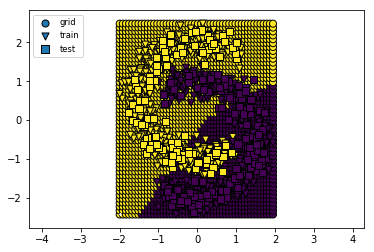

Model Parameters: Number of hidden units: 10, Early Stopping: True, Regularization: [0, 0], Learning Rate: 0.03
Best Validation accuracy:0.76704545454545459
(2500, 2)


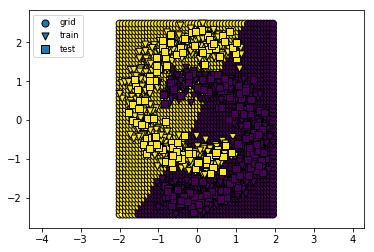

Model Parameters: Number of hidden units: 10, Early Stopping: True, Regularization: [0.01, 0.01], Learning Rate: 0.01
Best Validation accuracy:0.77272727272727271
(2500, 2)


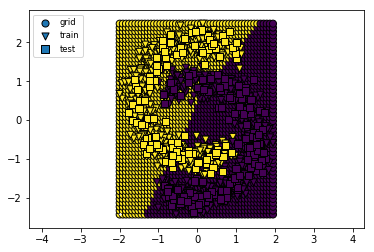

Model Parameters: Number of hidden units: 10, Early Stopping: True, Regularization: [0.01, 0.01], Learning Rate: 0.03
Best Validation accuracy:0.78409090909090906
(2500, 2)


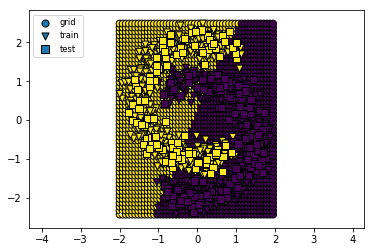

Model Parameters: Number of hidden units: 10, Early Stopping: False, Regularization: [0, 0], Learning Rate: 0.01
Best Validation accuracy:0.91477272727272729
(2500, 2)


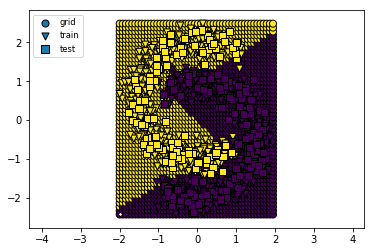

Model Parameters: Number of hidden units: 10, Early Stopping: False, Regularization: [0, 0], Learning Rate: 0.03
Best Validation accuracy:0.99431818181818177
(2500, 2)


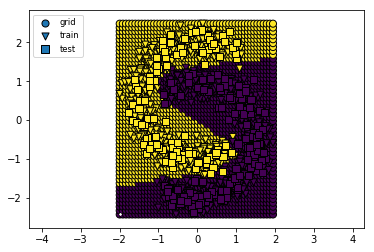

Model Parameters: Number of hidden units: 10, Early Stopping: False, Regularization: [0.01, 0.01], Learning Rate: 0.01
Best Validation accuracy:0.76136363636363635
(2500, 2)


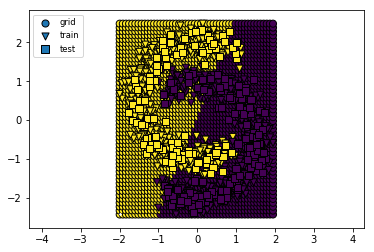

Model Parameters: Number of hidden units: 10, Early Stopping: False, Regularization: [0.01, 0.01], Learning Rate: 0.03
Best Validation accuracy:0.77840909090909094
(2500, 2)


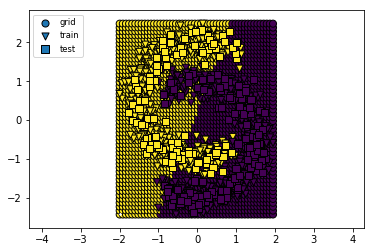

Model Parameters: Number of hidden units: 30, Early Stopping: True, Regularization: [0, 0], Learning Rate: 0.01
Best Validation accuracy:0.77272727272727271
(2500, 2)


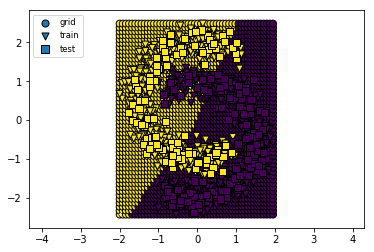

Model Parameters: Number of hidden units: 30, Early Stopping: True, Regularization: [0, 0], Learning Rate: 0.03
Best Validation accuracy:0.77272727272727271
(2500, 2)


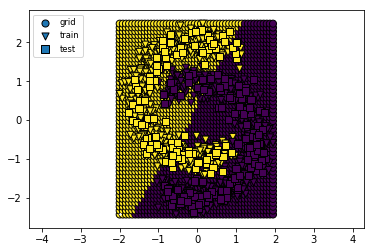

Model Parameters: Number of hidden units: 30, Early Stopping: True, Regularization: [0.01, 0.01], Learning Rate: 0.01
Best Validation accuracy:0.76704545454545459
(2500, 2)


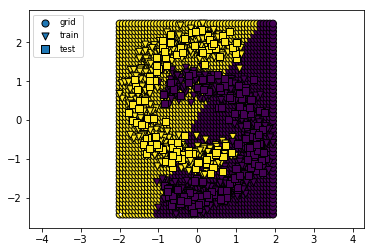

Model Parameters: Number of hidden units: 30, Early Stopping: True, Regularization: [0.01, 0.01], Learning Rate: 0.03
Best Validation accuracy:0.76704545454545459
(2500, 2)


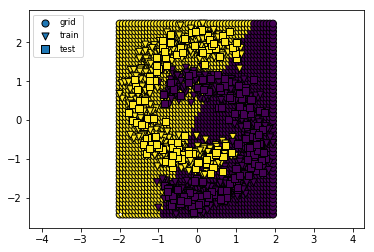

Model Parameters: Number of hidden units: 30, Early Stopping: False, Regularization: [0, 0], Learning Rate: 0.01
Best Validation accuracy:0.91477272727272729
(2500, 2)


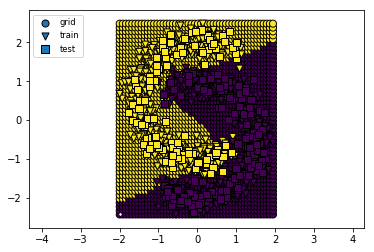

Model Parameters: Number of hidden units: 30, Early Stopping: False, Regularization: [0, 0], Learning Rate: 0.03
Best Validation accuracy:0.98863636363636365
(2500, 2)


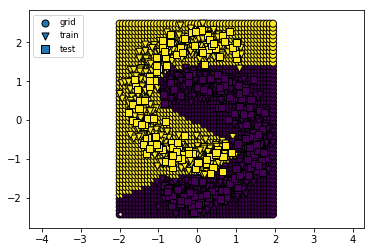

Model Parameters: Number of hidden units: 30, Early Stopping: False, Regularization: [0.01, 0.01], Learning Rate: 0.01
Best Validation accuracy:0.76704545454545459
(2500, 2)


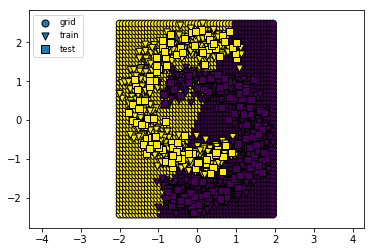

Model Parameters: Number of hidden units: 30, Early Stopping: False, Regularization: [0.01, 0.01], Learning Rate: 0.03
Best Validation accuracy:0.77840909090909094
(2500, 2)


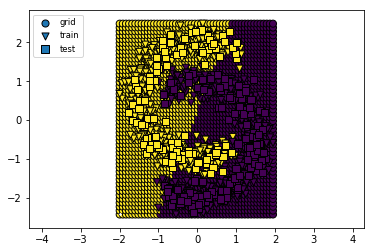

In [145]:
hyperparameters = {
    'n_hidden_units' : [[2,10,2],[2,30,2]],
    'early_stopping' : [True,False],
    'regularization' : [[0,0], [.01,.01]],
    'learning_rate' : [0.01,0.03]
}

for i in range(len(hyperparameters['n_hidden_units'])):
    for j in range(len(hyperparameters['early_stopping'])):
        for k in range(len(hyperparameters['regularization'])):
            for m in range(len(hyperparameters['learning_rate'])):
                print "Model Parameters: Number of hidden units: " + repr(hyperparameters['n_hidden_units'][i][1]) +\
                ", Early Stopping: " + repr(hyperparameters['early_stopping'][j]) + ", Regularization: " +\
                repr(hyperparameters['regularization'][k]) + ", Learning Rate: " + repr(hyperparameters['learning_rate'][m]) 
                model = NeuralNet_single(hyperparameters['n_hidden_units'][i],2,hyperparameters['regularization'][k])
                best_validation_accuracy = model.train(data_train_val,hyperparameters['learning_rate'][m],batch_size=25,
                            early_stopping=hyperparameters['early_stopping'][j],num_epochs=200,verbose=False)
                print "Best Validation accuracy:" + repr(best_validation_accuracy)
                gridplot(model,data_train_val,data_test)

Data Set Up: 2 Moons

Experiment 1,2: Gradient Check on a single example

In [5]:
np.random.seed(123)
singleNN = NeuralNet_single([2,2,2],2, [1,1])
#take one example
# reshape data from single column vectore to single row vector
singleNN.grad_check(data,0.00001,1)

(1, 2)
Second Bias gradients
Ratio of grads: 0.99999779627925045
Gradient b2[0]: Finite difference: -0.55927134390287847 Analytical: -0.55927257638345973
Ratio of grads: 1.0000022037214749
Gradient b2[1]: Finite difference: 0.55927380886444666 Analytical: 0.55927257638345973
Second weight gradients
Ratio of grads: 1.0000083415439478
Gradient W2[0,0]: Finite difference: 1.2602355670132681 Analytical: 1.2602250547905893
Ratio of grads: 0.99999178635135499
Gradient W2[0,1]: Finite difference: -1.217477773884923 Analytical: -1.2174877739017274
Ratio of grads: 1.0000038642642624
Gradient W2[1,0]: Finite difference: 2.7203439437961658 Analytical: 2.7203334317089043
Ratio of grads: 1.0000065669624372
Gradient W2[1,1]: Finite difference: 1.5227874460954636 Analytical: 1.5227774460731749
First bias gradients
Ratio of grads: 1.0000008145093664
Gradient b1[0]: Finite difference: 0.20666662887691697 Analytical: 0.20666646054514914
Ratio of grads: 1.0
Gradient b1[1]: Finite difference: 0.0 Analytic

Experiments 3,4: Gradient Check on minibatches

In [6]:
singleNN.grad_check(data,0.00001,10)

(10, 2)
Second Bias gradients
Ratio of grads: 1.0000171036707608
Gradient b2[0]: Finite difference: 0.072697865061144284 Analytical: 0.072696621682061605
Ratio of grads: 0.99998289682755503
Gradient b2[1]: Finite difference: -0.072695378339204808 Analytical: -0.072696621682061605
Second weight gradients
Ratio of grads: 1.0000065542196164
Gradient W2[0,0]: Finite difference: 1.5473188032188998 Analytical: 1.547308661818116
Ratio of grads: 0.99999154685252423
Gradient W2[0,1]: Finite difference: -1.1877927470926863 Analytical: -1.1878027877648234
Ratio of grads: 1.0000041677924205
Gradient W2[1,0]: Finite difference: 2.4332599659615539 Analytical: 2.4332498246813774
Ratio of grads: 1.0000067247838755
Gradient W2[1,1]: Finite difference: 1.4931025006603702 Analytical: 1.4930924599362709
First bias gradients
Ratio of grads: 1.0000015226790806
Gradient b1[0]: Finite difference: 0.044353379546890885 Analytical: 0.04435331201103053
Ratio of grads: 0.99999791921443792
Gradient b1[1]: Finite di